<a href="https://colab.research.google.com/github/hvr2026/Data-Science-Methodologies/blob/main/CRISP-DM/CrispDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [20]:
from sklearn.impute import SimpleImputer

In [41]:
# Step 1: Business Understanding
# Objective: Analyze the listing activity and factors affecting Airbnb prices and reviews.
# Load datasets
listings = pd.read_csv('/content/listings.csv')
reviews = pd.read_csv('/content/reviews.csv')
calendar = pd.read_csv('/content/calendar.csv')

In [21]:
# Step 2: Data Understanding
# Display basic information about each dataset
print("Listings Dataset Overview:\n", listings.info())
print(listings.head())
print("\nCalendar Dataset Overview:\n", calendar.info())
print(calendar.head())
print("\nReviews Dataset Overview:\n", reviews.info())
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [22]:
# Step 3: Data Preparation
# Convert price columns to numeric after removing "$" and any non-numeric characters
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

In [23]:
# Handle missing values in 'review_scores_rating' in the listings dataset
listings['review_scores_rating'].fillna(listings['review_scores_rating'].median(), inplace=True)

<ipython-input-23-7ef53559ec2a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings['review_scores_rating'].fillna(listings['review_scores_rating'].median(), inplace=True)


In [24]:
# Merge listings with calendar data on 'listing_id' to analyze combined data
data = pd.merge(calendar, listings, left_on='listing_id', right_on='id', how='left')

In [25]:
# Feature engineering - Adding month and year from date for seasonal analysis
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year


In [29]:
# Feature selection for modeling (based on available features in the listings dataset)
features = ['review_scores_rating', 'accommodates', 'bathrooms', 'bedrooms', 'number_of_reviews']
X = listings[features]
y = listings['price']


In [30]:
# Handle missing values in features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

In [32]:
# Step 4: Modeling and Addressing Underfitting/Overfitting
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [33]:
# Random Forest Regressor Model with Cross-Validation
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [34]:
# Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
print("Random Forest Cross-Validated MAE:", -np.mean(cv_scores_rf))

Random Forest Cross-Validated MAE: 43.20610859288629


In [35]:
# Step 5: Evaluation

# Calculate MAE for both models
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))

# R^2 and RMSE for Random Forest
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest R^2 Score:", rf_r2)
print("Random Forest RMSE:", rf_rmse)


Linear Regression MAE: 42.0676881272673
Random Forest MAE: 43.517825391335066
Random Forest R^2 Score: 0.4747224955062994
Random Forest RMSE: 67.06891749336424


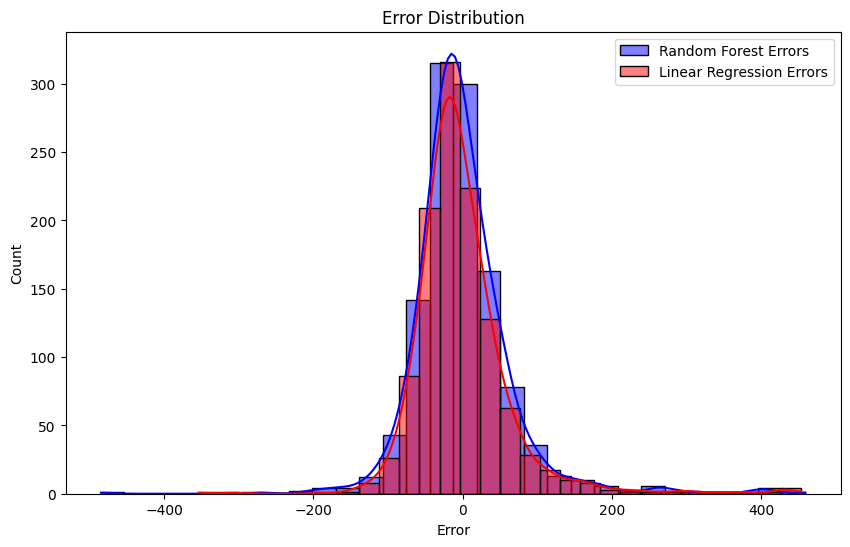

In [36]:
# Plotting error distributions for both models
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred_rf, kde=True, color='blue', label="Random Forest Errors", bins=30)
sns.histplot(y_test - y_pred_lr, kde=True, color='red', label="Linear Regression Errors", bins=30)
plt.title("Error Distribution")
plt.xlabel("Error")
plt.legend()
plt.show()


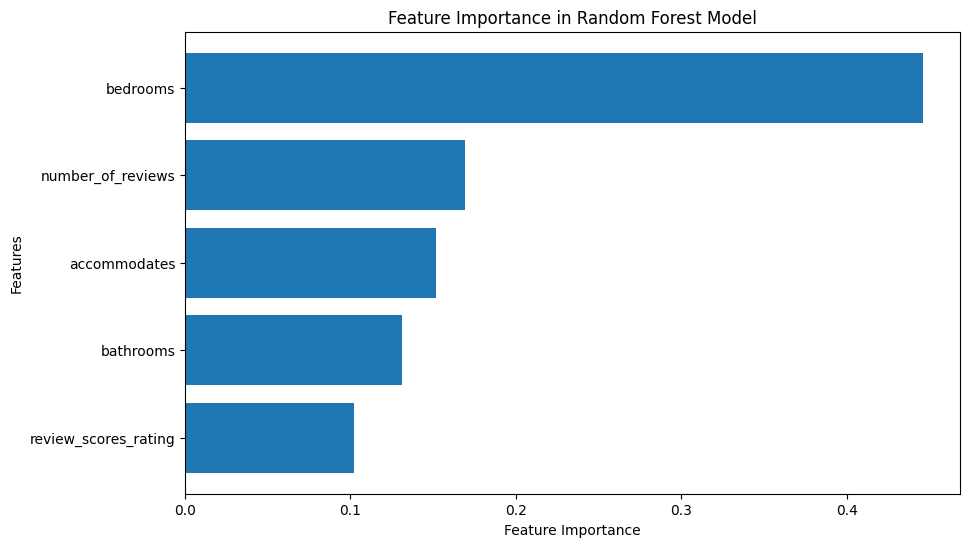

In [37]:
# Feature Importance in Random Forest Model
feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], np.array(feature_importances)[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

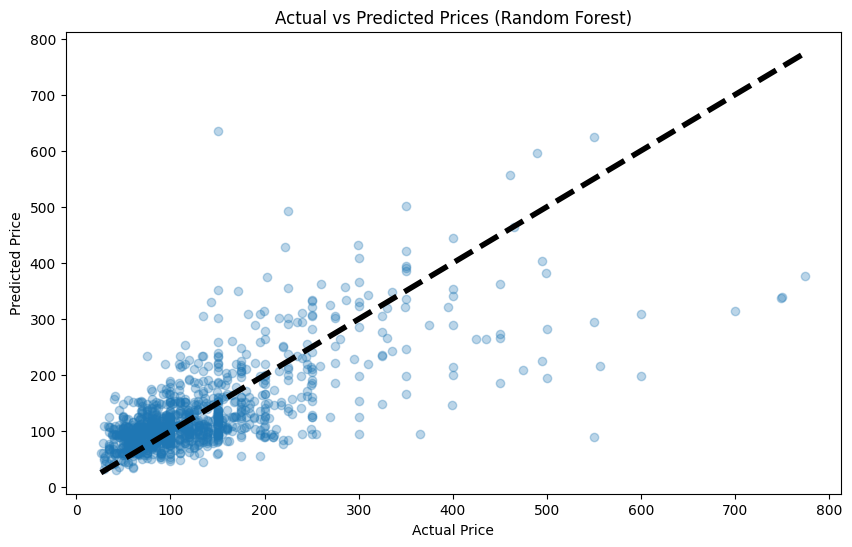

In [38]:
# Plotting Actual vs Predicted Prices for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.show()

In [39]:
# Step 6: Deployment (Insights)
# Analyze and summarize key findings to provide actionable insights

print("Insights:")
print("1. Feature Importance Analysis:")
print("   - Based on the Random Forest model, the most influential features impacting Airbnb pricing include:")
for feature, importance in zip(np.array(features)[sorted_idx], np.array(feature_importances)[sorted_idx]):
    print(f"     * {feature}: Importance Score = {importance:.4f}")
print("   - This suggests that attributes like the number of bedrooms, bathrooms, and review scores have a significant impact on the price, helping hosts understand which features to focus on when setting competitive prices.")


Insights:
1. Feature Importance Analysis:
   - Based on the Random Forest model, the most influential features impacting Airbnb pricing include:
     * review_scores_rating: Importance Score = 0.1023
     * bathrooms: Importance Score = 0.1311
     * accommodates: Importance Score = 0.1515
     * number_of_reviews: Importance Score = 0.1690
     * bedrooms: Importance Score = 0.4461
   - This suggests that attributes like the number of bedrooms, bathrooms, and review scores have a significant impact on the price, helping hosts understand which features to focus on when setting competitive prices.
